In [18]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from PIL import Image
import io
import os

In [19]:
current_dir =  os.getcwd()
train_file = 'train-00000-of-00001-c08a401c53fe5312.parquet'
data_path = os.path.join(current_dir,'Data',train_file)

# Load the Parquet file
df = pd.read_parquet(data_path, engine='pyarrow')
df.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [20]:
# Function to decode image bytes and convert to NumPy array
def decode_image(image_dict):
    try:
        byte_string = image_dict['bytes']
        image_stream = io.BytesIO(byte_string)
        image_pil = Image.open(image_stream)
        image_np = np.array(image_pil)
        return image_np
    except Exception as e:
        print(f"Error decoding image: {e}")
        return None
df['image_np'] = df['image'].apply(decode_image)

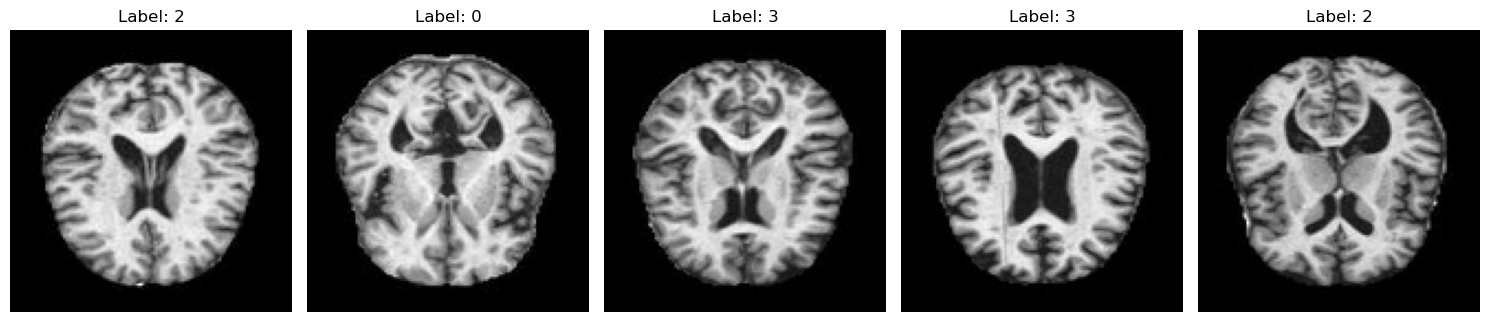

In [21]:
# Display a sample of five images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    img_np = df['image_np'].iloc[i]
    label = df['label'].iloc[i]
    axes[i].imshow(img_np, cmap='gray') 
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

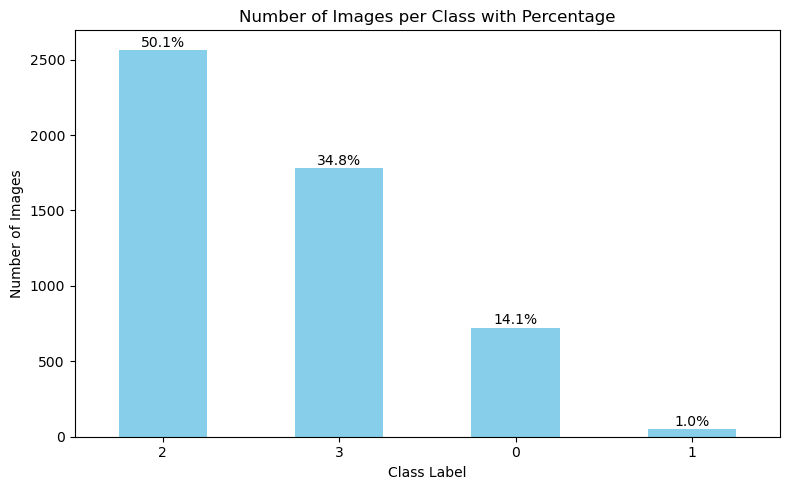

In [22]:
# Count occurrences of each class label
class_counts = df['label'].value_counts()

# Calculate percentages
total_images = len(df)
class_percentages = class_counts / total_images * 100

#Barplot with Percentage for each class
plt.figure(figsize=(8, 5))
bars = class_counts.plot(kind='bar', color='skyblue')

for bar, percentage in zip(bars.patches, class_percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.2, f'{percentage:.1f}%', ha='center', va='bottom')

plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class with Percentage')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

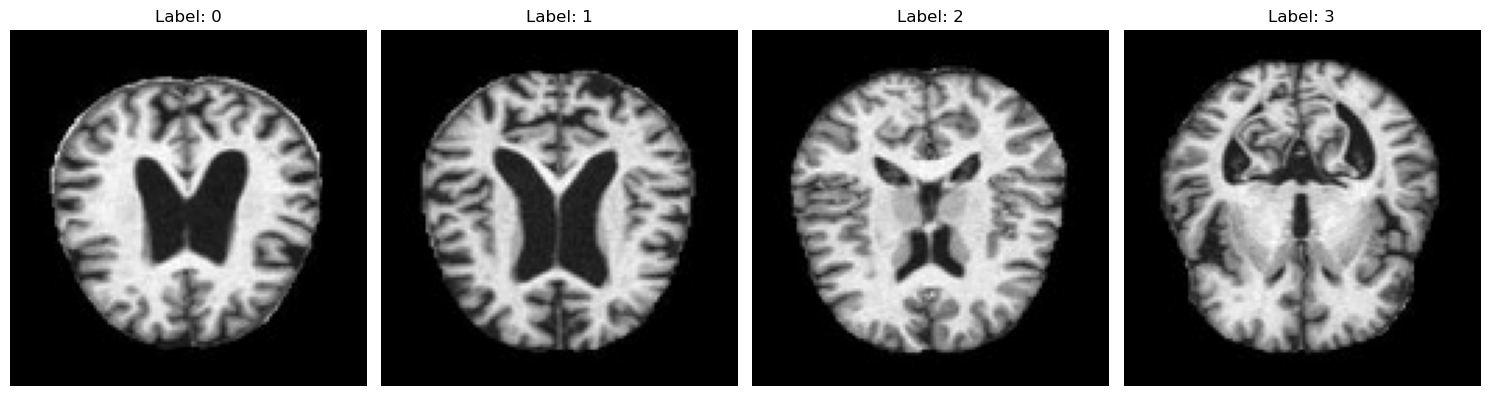

In [23]:
# Sample for each class of images
sample_per_class = df.groupby('label').apply(lambda x: x.sample(1))

# Display sampled images for each class 
fig, axes = plt.subplots(1, len(sample_per_class), figsize=(15, 5))
for i, (_, row) in enumerate(sample_per_class.iterrows()):
    img_np, label = row['image_np'], row['label']
    axes[i].imshow(img_np, cmap='gray') 
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [24]:
# Function to get dimensions of an image
def get_dimensions(image_np):
    if image_np is not None:
        return image_np.shape[:2] 
    else:
        return None, None
df['dimensions'] = df['image_np'].apply(get_dimensions)

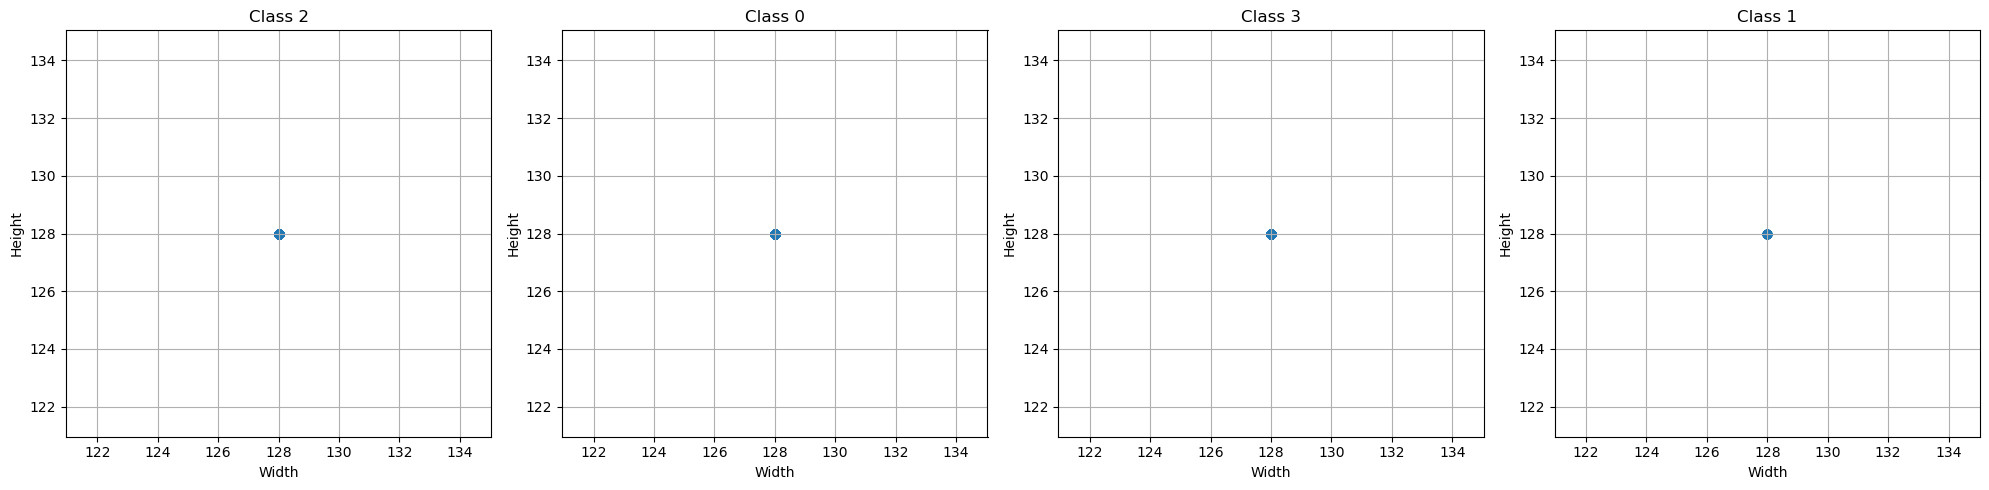

In [25]:
df[['height', 'width']] = pd.DataFrame(df['dimensions'].tolist(), index=df.index)
# Create subplots for each class
classes = df['label'].unique()
fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))

for i, cls in enumerate(classes):
    subset = df[df['label'] == cls]
    axes[i].scatter(subset['width'], subset['height'], alpha=0.6)
    axes[i].set_title(f'Class {cls}')
    axes[i].set_xlabel('Width')
    axes[i].set_ylabel('Height')
    axes[i].grid(True)

plt.tight_layout()
plt.show()